# Load images from new Echelle

## Imports and Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go
from lmfit.models import GaussianModel
from ipywidgets import interact,widgets
from intersect import intersection

In [2]:
# Don't know how to import locally, so I just use %run
%run ../tools/echelle.py

In [3]:
files_fujii = {
    "orders": "pattern_fujii.txt",
    "wavelength": "wavelength_fujii.txt",
    "sphr": "Sep28_2022_175416_100ms_sekibunki.tif",
    "bkgr": "Sep28_2022_175455_100ms_sekibunki-dark.tif",
    "integral": "integrating_sphere.txt",
}
#wv = np.loadtxt('./data/fulcher-α_band_wavelength.txt')

In [4]:
%run ../tools/echelle.py
folder = './data'
#crop = [1400,2600]
#files_fujii['orders'] = "pattern_fujii.txt"
crop = [1300,2950]
files_fujii['orders'] = "pattern_fujii-1.txt"
cb = Calibrations(folder,files_fujii,spec='fujii',dv=17,crop=crop)
cb.start()

In [5]:
bpth = folder
fname = 'Sep28_2022_175416_100ms_sekibunki.tif'
sphr = EchelleImage(os.path.join(bpth,fname),clbr=cb,spec='fujii',crop=crop)
fname = 'Sep28_2022_175455_100ms_sekibunki-dark.tif'
sphrbg = EchelleImage(os.path.join(bpth,fname),clbr=cb,spec='fujii',crop=crop)
sphr.calculate_order_spectra()
sphrbg.calculate_order_spectra()

In [5]:
bpth = './data'
lamps = ['H2-lamp-Fulcher-1s--20C.tif','Sep28_2022_174758_100ms_ThAr.tif','Sep29_2022_191811_5ms_FeNe.tif','Sep29_2022_191832_100ms_FeNe.tif']

h2 = EchelleImage(os.path.join(bpth,lamps[0]),clbr=cb,spec='fujii',crop=crop)
h2.calculate_order_spectra()
h2.calculate_spectra()

In [6]:
def plotfunc(lamp):
    h2 = EchelleImage(os.path.join(bpth,lamp),clbr=cb,spec='fujii',crop=crop)
    h2.calculate_order_spectra()
    h2.calculate_spectra()

    x = h2.wavelength
    y = h2.spectra[0]

    pg_data = [go.Scatter(x=x,y=y)]
    fig = go.Figure(data=pg_data)
    fig.update_layout(template='plotly_white')
    fig.show()


interact(plotfunc, lamp = widgets.Dropdown(options=lamps,description='lamp file'))

interactive(children=(Dropdown(description='lamp file', options=('H2-lamp-Fulcher-1s--20C.tif', 'Sep28_2022_17…

<function __main__.plotfunc(lamp)>

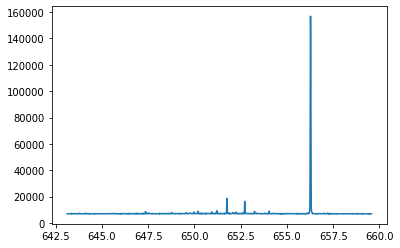

In [15]:
order = 11
y = h2.order_spectra[0][order]
x = cb.order_wavel[order]
plt.plot(x,y)

In [8]:
x = h2.wavelength
y = h2.spectra[0]

pg_data = [go.Scatter(x=x,y=y,name = 'a')]
fig = go.Figure(data=pg_data)
fig.update_layout(template='plotly_white')
fig.show()

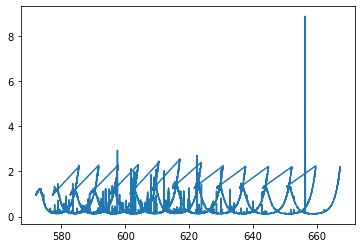

In [9]:
sp = Spectrum(h2)
plt.plot(sp.wavelength,sp.wm[0])

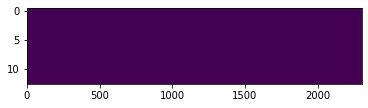

In [10]:
plt.imshow(cb.order_borders,aspect=40)

In [11]:
def isc(x1, y1, x2, y2):
    """For two neighbor orders with lambda \propto -pix
    find end index for x1 and start index for x2 so they will
    not intersect
    x1 < ind1 and x2 >= ind2
    """
    from scipy.interpolate import interp1d

    # remove np.nan from vectors
    i1 = ~np.isnan(x1)
    i2 = ~np.isnan(x2)
    x1 = x1[i1]
    y1 = y1[i1]
    x2 = x2[i2]
    y2 = y2[i2]

    f1 = interp1d(x1, y1, 1)
    f2 = interp1d(x2, y2, 1)
    x = np.linspace(*sorted([x1[0], x1[-1], x2[0], x2[-1]])[1:-1], len(x2))
    x0 = x[np.argmin(np.abs(f1(x) - f2(x)))]
    ind2 = np.where(x2 <= x0)
    ind1 = np.where(x1 > x0)

    return ind1[0][-1] + 1, ind2[0][0]

In [12]:
o = 2
isc(
    h2.clbr.order_wavel[o],
    h2.clbr.sphr.order_spectra[0, o],
    h2.clbr.order_wavel[o + 1],
    h2.clbr.sphr.order_spectra[0, o + 1],
)

(2304, 0)

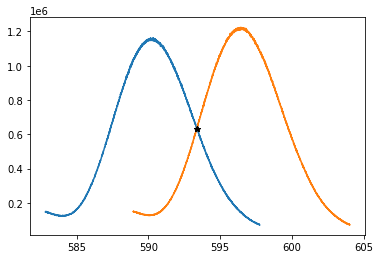

In [13]:
o = 2
x1 = h2.clbr.order_wavel[o]
y1 = h2.clbr.sphr.order_spectra[0, o]
x2 = h2.clbr.order_wavel[o + 1]
y2 = h2.clbr.sphr.order_spectra[0, o + 1]
x,y = intersection(x1,y1,x2,y2)
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.plot(x,y,'*k')

In [14]:
from scipy.interpolate import interp1d

o = 2
x1 = h2.clbr.order_wavel[o]
y1 = h2.clbr.sphr.order_spectra[0, o]
x2 = h2.clbr.order_wavel[o + 1]
y2 = h2.clbr.sphr.order_spectra[0, o + 1]
if x1[0]<x2[0]:
    # swap places
    print(x1[0],x2[0])
    a,b = x1,y1
    x1,y1 = x2,y2
    x2,y2 = a,b
# remove np.nan from vectors
i1 = ~np.isnan(x1)
i2 = ~np.isnan(x2)
x1 = x1[i1]
y1 = y1[i1]
x2 = x2[i2]
y2 = y2[i2]

f1 = interp1d(x1, y1, 1)
f2 = interp1d(x2, y2, 1)
x = np.linspace(*sorted([x1[0], x1[-1], x2[0], x2[-1]])[1:-1], len(x2))
x0 = x[np.argmin(np.abs(f1(x) - f2(x)))]
ind2 = np.where(x2 <= x0)
ind1 = np.where(x1 > x0)

ind1[0][0] + 1, ind2[0][-1]

582.8098122366777 588.9391376588179


(627, 1572)

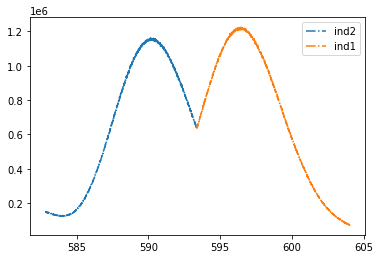

In [15]:
#plt.plot(x,f1(x),label='1')
#plt.plot(x,f2(x),label='2')
#plt.plot(x,np.abs(f1(x)-f2(x)))
#plt.axvline(x0,c='k')
plt.plot(x2[ind2],y2[ind2],'-.',label='ind2')
plt.plot(x1[ind1],y1[ind1],'-.',label='ind1')
plt.legend()

In [16]:
x1[0]>x2[0]

True

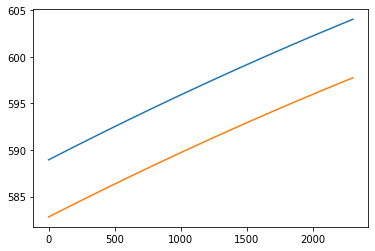

In [17]:
plt.plot(x1)
plt.plot(x2)

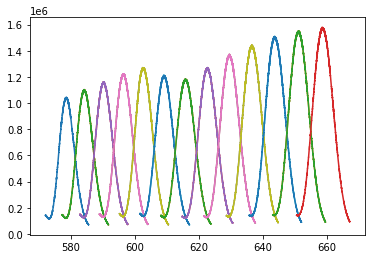

In [18]:
for o in range(12):
    plt.plot(h2.clbr.order_wavel[o],h2.clbr.sphr.order_spectra[0, o])
    plt.plot(h2.clbr.order_wavel[o + 1],h2.clbr.sphr.order_spectra[0, o + 1])